# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [1]:
import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Number of rows in the DataFrame: 1000
Percentage of 'Liked' reviews: 50.00%


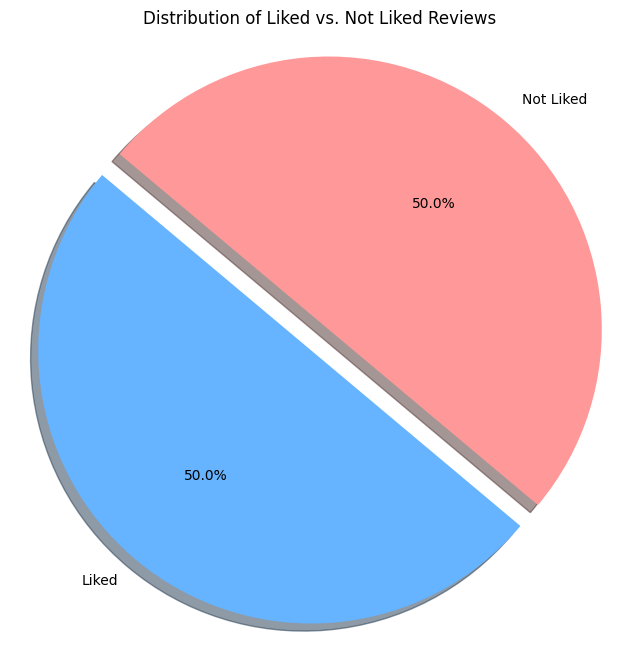

In [2]:
import matplotlib.pyplot as plt

# Add code here 🔧
print(f"Number of rows in the DataFrame: {df.shape[0]}")
liked_percentage = df['Liked'].mean() * 100
print(f"Percentage of 'Liked' reviews: {liked_percentage:.2f}%")

# Count the occurrences of 'Liked' and 'Not Liked'
like_counts = df['Liked'].value_counts()

# Prepare labels and sizes for the pie chart
labels = ['Liked' if index == 1 else 'Not Liked' for index in like_counts.index]
sizes = like_counts.values
colors = ['#66b3ff', '#ff9999'] # Blue for Liked, Red for Not Liked
explode = (0.1, 0)  # Explode the 'Liked' slice for emphasis

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Liked vs. Not Liked Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


In [3]:
# Add code here 🔧
import re

# 1. Change all of the reviews to lowercase letters
df['Review'] = df['Review'].str.lower()

# 2. Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
# Keep only alphanumeric characters and spaces
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

# 3. Remove punctuation marks (ex. !.,-:;)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-z0-9 ]', '', x))

df.head()

,Review,Liked
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### ✍️ Your Response: 🔧
1. If junk is "included" in the model, it can mess with the outputs of the model by skewing results or the readings being wrong.

## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


In [5]:
# Add code here 🔧
!pip install vaderSentiment
import pandas as pd
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score and classify
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the 'Review' column
df['Sentiment'] = df['Review'].apply(get_sentiment)

# Calculate the percentage of each sentiment category
sentiment_counts = df['Sentiment'].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100

print("Sentiment Distribution:")
print(sentiment_percentages)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00
Sentiment Distribution:
Sentiment
Positive    50.6
Negative    25.5
Neutral     23.9
Name: count, dtype: float64


### ✍️ Your Response: 🔧
1.  In terms of percentage of reviews, the sentiment seems to be similar.

2. From an owner's perspective, the negative reviews would be the most important to analyze because it will show where the restraunt needs to improbve. However, the positive reviews are close to as important in order to highlight what the restraunt does and should keep doing well.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


In [16]:
# Add code here 🔧
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK corpora
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = []
    for word in tokens:
        if word not in stop_words:
            processed_tokens.append(lemmatizer.lemmatize(word))
    # Join tokens back into a string
    return ' '.join(processed_tokens)

# Apply preprocessing to the 'Review' column
df['Processed_Review'] = df['Review'].apply(preprocess_text)

# Display the first 10 processed reviews
print("First 10 processed reviews:")
print(df[['Review', 'Processed_Review']].head(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


First 10 processed reviews:
                                              Review  \
0                               wow loved this place   
1                                  crust is not good   
2           not tasty and the texture was just nasty   
3  stopped by during the late may bank holiday of...   
4  the selection on the menu was great and so wer...   
5      now i am getting angry and i want my damn pho   
6                 honeslty it didnt taste that fresh   
7  the potatoes were like rubber and you could te...   
8                           the fries were great too   
9                                      a great touch   

                                    Processed_Review  
0                                    wow loved place  
1                                         crust good  
2                                tasty texture nasty  
3  stopped late may bank holiday rick steve recom...  
4                         selection menu great price  
5                        

### ✍️ Your Response: 🔧
1.  A corpora is a structured collection of written or spoken texts. It is used for text analysis in order to give a baseline for the model to compare and use for reference.

2. The tokens in the first review would be "loved" and perhaps "wow".

3. Leminization reduces a word to its base or dictionary form. It will help for more easier analysis and identification of words.


## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

In [17]:
# Add code here 🔧
!pip install gensim
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel

# Create a dictionary from the processed reviews
dictionary = Dictionary([review.split() for review in df['Processed_Review']])

# Filter out words that appear in less than 5 documents or more than 90% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.9)

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(review.split()) for review in df['Processed_Review']]

# Display a summary of the dictionary and corpus
print(f"Number of unique tokens in dictionary: {len(dictionary)}")
print(f"Number of documents in corpus: {len(corpus)}")
print("Example of a document in corpus (first document):")
print(corpus[0])
print("Mapping of IDs to words (first 10):")
print({dictionary[id]: freq for id, freq in corpus[0] if id in dictionary})


Number of unique tokens in dictionary: 260
Number of documents in corpus: 1000
Example of a document in corpus (first document):
[(0, 1), (1, 1)]
Mapping of IDs to words (first 10):
{'loved': 1, 'place': 1}


### ✍️ Your Response: 🔧
1. A corpus is a collection of text or audio organized into datasets. It is useful for nlp's to use to reference to see how words are used.

2. A dictionary is different from a corpus beccause a corpus is made of text and application of words, while a dictionary is purely words.

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


In [20]:
# Add code here 🔧
num_topics = 5

# Create the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

print("LDA Model Summary:")
print(lda_model.print_topics())

LDA Model Summary:
[(0, '0.101*"great" + 0.041*"food" + 0.038*"friendly" + 0.030*"service" + 0.023*"best" + 0.022*"staff" + 0.022*"always" + 0.021*"get" + 0.020*"experience" + 0.016*"menu"'), (1, '0.062*"service" + 0.047*"time" + 0.036*"like" + 0.030*"nice" + 0.028*"food" + 0.027*"restaurant" + 0.025*"delicious" + 0.024*"place" + 0.020*"better" + 0.019*"really"'), (2, '0.103*"good" + 0.047*"go" + 0.039*"place" + 0.031*"food" + 0.028*"back" + 0.027*"like" + 0.021*"salad" + 0.020*"service" + 0.019*"selection" + 0.019*"night"'), (3, '0.069*"food" + 0.035*"also" + 0.025*"amazing" + 0.025*"one" + 0.025*"place" + 0.025*"disappointed" + 0.024*"star" + 0.019*"love" + 0.019*"good" + 0.018*"minute"'), (4, '0.071*"place" + 0.066*"back" + 0.040*"ever" + 0.035*"never" + 0.030*"ive" + 0.029*"wont" + 0.025*"eat" + 0.025*"definitely" + 0.022*"would" + 0.022*"worst"')]


### ✍️ Your Response: 🔧
1. Cases in which you would want more than 5 topics is when there are multiple themes of text that you want to identify.

2. You would know if you have too many topics if there are little to no responses, or they start repeating/overlapping.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"


LDA Topics and their top 10 words:
Topic #0: 0.101*"great" + 0.041*"food" + 0.038*"friendly" + 0.030*"service" + 0.023*"best" + 0.022*"staff" + 0.022*"always" + 0.021*"get" + 0.020*"experience" + 0.016*"menu"
Topic #1: 0.062*"service" + 0.047*"time" + 0.036*"like" + 0.030*"nice" + 0.028*"food" + 0.027*"restaurant" + 0.025*"delicious" + 0.024*"place" + 0.020*"better" + 0.019*"really"
Topic #2: 0.103*"good" + 0.047*"go" + 0.039*"place" + 0.031*"food" + 0.028*"back" + 0.027*"like" + 0.021*"salad" + 0.020*"service" + 0.019*"selection" + 0.019*"night"
Topic #3: 0.069*"food" + 0.035*"also" + 0.025*"amazing" + 0.025*"one" + 0.025*"place" + 0.025*"disappointed" + 0.024*"star" + 0.019*"love" + 0.019*"good" + 0.018*"minute"
Topic #4: 0.071*"place" + 0.066*"back" + 0.040*"ever" + 0.035*"never" + 0.030*"ive" + 0.029*"wont" + 0.025*"eat" + 0.025*"definitely" + 0.022*"would" + 0.022*"worst"
DataFrame with 'Dominant_Topic' column added:
                                              Review  Liked Sent

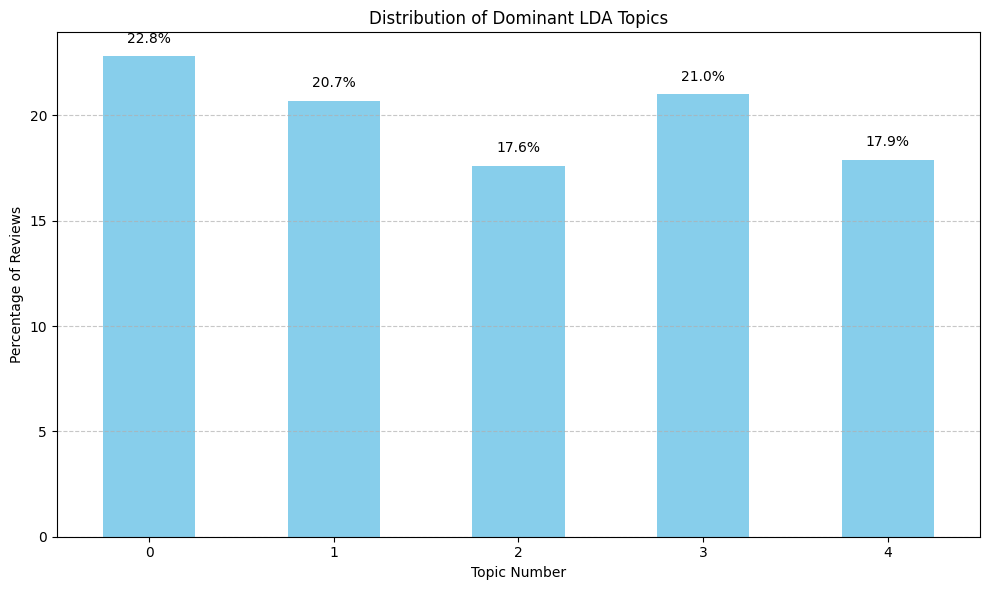

Sentiment Distribution by Dominant Topic (%):
Sentiment        Negative    Neutral   Positive
Dominant_Topic                                 
0               23.245614  21.052632  55.701754
1               22.222222  18.840580  58.937198
2               23.295455  21.022727  55.681818
3               29.523810  27.142857  43.333333
4               29.608939  32.402235  37.988827


In [27]:
# Add code here 🔧
print("LDA Topics and their top 10 words:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic #{idx}: {topic}")

def get_dominant_topic(lda_model, bow_vector):
    # Get the topic distribution for the document
    topic_distribution = lda_model.get_document_topics(bow_vector)
    # Find the topic with the highest probability
    if topic_distribution:
        dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    else:
        dominant_topic = None # Or handle as appropriate for empty reviews
    return dominant_topic

# Apply the function to each review's bag-of-words representation in the corpus
df['Dominant_Topic'] = [get_dominant_topic(lda_model, doc) for doc in corpus]

print("DataFrame with 'Dominant_Topic' column added:")
print(df.head())

topic_distribution = df['Dominant_Topic'].value_counts(normalize=True) * 100
print("Dominant Topic Distribution (%):")
print(topic_distribution.sort_index())

# Sort the topic distribution by topic index for consistent plotting
topic_distribution_sorted = topic_distribution.sort_index()

plt.figure(figsize=(10, 6))
topic_distribution_sorted.plot(kind='bar', color='skyblue')
plt.title('Distribution of Dominant LDA Topics')
plt.xlabel('Topic Number')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=0) # Ensure topic numbers are readable
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of the bars
for index, value in enumerate(topic_distribution_sorted):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

sentiment_by_topic = df.groupby('Dominant_Topic')['Sentiment'].value_counts(normalize=True).unstack().fillna(0) * 100
print("Sentiment Distribution by Dominant Topic (%):")
print(sentiment_by_topic)

### ✍️ Your Response: 🔧
List your topics and names here:

Topic #0: Great Service/Food
Topic #1: Restaurant Experience
Topic #2: Good Food/Place
Topic #3: Amazing Food
Topic #4: Negative Experience


## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
1. D

2. D

3. D

4. D

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [ ]:
!jupyter nbconvert --to html "assignment_11_LastnameFirstname.ipynb"